** Notes **

[Sklearn's K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) supports sparse matrices

However the Gaussian Mixture model does not, and as such I subsample the IMDB dataset so that it fits into memory

### Initial Setup

In [0]:
import keras
from sklearn import metrics
from sklearn.model_selection import train_test_split
import numpy as np
import time
import sklearn
import pylab
import matplotlib.pyplot as plt
import scipy
import itertools
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import nltk
import os.path
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from skimage.color import rgb2gray
from sklearn.exceptions import DataConversionWarning
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection as GRP
from sklearn.random_projection import SparseRandomProjection as SRP
from sklearn.feature_selection import VarianceThreshold as VTSelector
from copy import deepcopy
from sklearn.preprocessing import OneHotEncoder
import torch.nn
import warnings
import keras.layers as layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
import keras.layers as layers
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils 
from matplotlib.cbook.deprecation import MatplotlibDeprecationWarning
import json
try:
    from google.colab import files
except ImportError:
  print("[0x000] | " + "Not running on colab")
  
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture

# Hopefully memory is less of an issue with colab, but I'll keep this in case
NP_DATA_TYPE = np.float32

IMDB = "IMDB"
DATASET = IMDB

PCA_CODE = "PCA"
ICA_CODE = "ICA"
RANDPROJ_CODE = "Randomized Projections"

KEY_PREPROC = "preproc"
KEY_DIMRED = "dimred"
KEY_CLUST = "clust"
KEY_PIPELINE = "pipeline"
KEY_TRAINING = "training"
KEY_REPS = "reps"

Using TensorFlow backend.


### Common methods used throughout

In [0]:
def augmented_split(*args, test_size=None, shuffle=True, random_state=None):
  
    if test_size < 0 or test_size >= 1:
        raise RuntimeError("Cant handle test fraction of ", str(test_size))
    
    if test_size == 0:
        out = [(a, None) for a in args]
        return itertools.chain(*out)
    else:
      return train_test_split(*args, 
                              test_size=test_size, 
                              shuffle=shuffle,
                              random_state=random_state)
    
def split_dataset(dataset, test_over_total, val_over_train): 
    x, y = dataset
    
    x_train, x_test, y_train, y_test = augmented_split(x, y, test_size=test_over_total)
    x_train, x_val, y_train, y_val = augmented_split(x_train, y_train, test_size=val_over_train)
    
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

def flatten_data_array(X):
    # Given an array X where X[i] is the ith data tensor, return an array X'
    # where X'[i] is the flattened data of the ith data tensor
    num_datapoints = X.shape[0]
    datum_size = np.prod(X.shape[1:])
    return X.reshape([num_datapoints, datum_size])

def get_pipeline(pipeline_spec):
  
    # Pipeline spec should be an array of tuples, each in the format
    # (step_name, step_class, step_args)
    pipe_args = []
    
    for spec in pipeline_spec:
        pipe_args.append((spec[0], spec[1](**spec[2])))
            
    return Pipeline(pipe_args)

def train_pipeline(config, train_data, test_data, fitness_metrics, verbose=1):
  
    repeats = config[KEY_TRAINING][KEY_REPS]
  
    pipelines = [None] * repeats
    train_results = [None] * repeats
    test_results = [None] * repeats
    
    x_train, y_train = train_data
    x_test, y_test = test_data
    
    if verbose >= 1:
        print("[0x001] | " + "Run Configuration: ", config)
    
    for index in range(repeats):
      
        if verbose >= 2:
            print("[0x002] | " + "Repetition ", index)
      
        pipelines[index] = get_pipeline(config[KEY_PIPELINE])
        
        start_fit = time.time()
        pipelines[index].fit(x_train, y_train)
        end_fit = time.time()
        if verbose >= 3:
            print("[0x003] | " + "Fit data in ", (end_fit - start_fit), " seconds")
        
        start_eval = time.time()
        train_results[index], test_results[index] = eval_clustering_pipeline(pipelines[index], 
                                                                             (train_set, test_set),
                                                                             fitness_metrics)
        end_eval = time.time()
        if verbose >= 3:
            print("[0x004] | " + "Predicted & Evaluated results in ", (end_eval - start_eval), " seconds")
        
        if verbose >= 2: 
            print("[0x005] | " + "Train/Test results are ", np.array(train_results[index]), 
                  np.array(test_results[index]))
        
    return pipelines, train_results, test_results
  
def eval_clustering_pipeline(pipeline, dataset_list, fitness_metric_list):
  
    """
    :pipeline: An sklearn pipeline implementing the predict function
    :dataset_list: A list of (x, y) tuples
    :fitness_metric_list: A list of functions (see sklearn.accuracy_metric for signature)
    """
    
    rets = []
    for x, y in dataset_list:
        preds = pipeline.predict(x)
        rets.append(np.array([metric(y, preds) for metric in fitness_metric_list]))
        
    return tuple(rets)
        
def sweep_pipelines(pipeline_configs, train_data, test_data, fitness_metrics, verbose):
            
    pipelines = [None] * len(pipeline_configs)
    config_train_avgs = [None] * len(pipelines)
    config_test_avgs = [None] * len(pipelines)

    for index, config in enumerate(pipeline_configs):
        print("[0x006] | " + "===================================")
        print("[0x007] | " + "Pipeline run ", index)
        
        start_time = time.time()
        warnings.filterwarnings(action='ignore', category=DataConversionWarning)
        
        all_config_pipelines, \
            all_config_train_results, \
            all_config_test_results = train_pipeline(config, train_data, test_data, 
                                                     fitness_metrics, verbose=verbose)
        
        warnings.resetwarnings()
        end_time = time.time()
        
        pipelines[index] = all_config_pipelines
        config_train_avgs[index] = np.average(all_config_train_results, axis=0)
        config_test_avgs[index] = np.average(all_config_test_results, axis=0)
        
        print("[0x008] | " + "Finished in ", (end_time - start_time), " seconds")
        print("[0x009] | " + "Average Train Scores: ", config_train_avgs[index])
        print("[0x00a] | " + "Average Test Scores: ", config_test_avgs[index])
        
    return pipelines, config_train_avgs, config_test_avgs
  
def index_of_stepname_in_pipeline(stepname, pipeline_specs):
    c = [ii for ii, thing in enumerate(pipeline_specs) if thing[0] == stepname]
    if c is None:
        raise RuntimeError("Couldn't find the specified step in the config :(")
    elif len(c) > 1:
        raise RuntimeError("Two indices corresponding to this pipeline?")
    return c[0]
  
def param_experiment(param_name, param_vals, tform, optimal_config, train_set, test_set, clustering_fitnesses, verbose=1):
  
    param_step_configs = [None] * len(param_vals)
    
    for index, _ in enumerate(param_step_configs):
  
        clust_index = index_of_stepname_in_pipeline(KEY_CLUST, optimal_config[KEY_PIPELINE])
        param_step_configs[index] = deepcopy(optimal_config)
        param_step_configs[index][KEY_PIPELINE][clust_index][2][param_name] = tform(param_vals[index])
    
    pipelines, avg_train_results, avg_test_results = sweep_pipelines(param_step_configs,
                                                                     train_set,
                                                                     test_set,
                                                                     clustering_fitnesses,
                                                                     verbose=verbose
                                                                    )
                                                                   
    return pipelines, avg_train_results, avg_test_results 
  
def size_experiment(config, dataset, train_frac_list, test_frac, clustering_fitnesses):
  
    train_set, _, test_set = split_dataset(dataset, test_frac, 0)
    _ = None
    
    pipelines = [None] * len(train_frac_list)
    avg_train_results = [None] * len(train_frac_list)
    avg_test_results = [None] * len(train_frac_list)
    
    for index, tfrac in enumerate(train_frac_list):
        print("[0x00b] | " + "Size Experiment: ", index)
        print("[0x00c] | " + "Train Fraction: ", tfrac, " of ", (1 - test_frac))
        curr_train_set, _, _ = split_dataset(train_set, 0, 1 - tfrac)
        _ = None
        
        start_time = time.time()
        warnings.filterwarnings(action='ignore', category=DataConversionWarning)
        
        pipelines[index], all_train_results, all_test_results = train_pipeline(config, 
                                                                curr_train_set, test_set,
                                                                clustering_fitnesses)
        
        warnings.resetwarnings()
        end_time = time.time()
        
        avg_train_results[index] = np.average(all_train_results, axis=0)
        avg_test_results[index] = np.average(all_test_results, axis=0)
        
        print("[0x00d] | " + "Finished in ", (end_time - start_time), " seconds")
        print("[0x00e] | " + "Average Train Scores: ", avg_train_results[index])
        print("[0x00f] | " + "Average Test Scores: ", avg_test_results[index])
        
    return pipelines, avg_train_results, avg_test_results
  
def plot_clustering_metrics(title, xaxis_label, xvals, train_results, test_results,
                           linewidth=2, markersize=15):

    xvals = np.array(xvals)
    train_results = np.array(train_results)
    test_results = np.array(test_results)

    assert(train_results.shape == test_results.shape)
    assert(len(xvals) == train_results.shape[0])
    # Three because I've been keeping track of three metrics of course!
    assert(train_results.shape[1] == 3)
    
    plt.title(title)
    plt.xlabel(xaxis_label)
    
    plt.plot(xvals, train_results[:,0], 'bo-', label="Train Rand",linewidth=linewidth, markersize=markersize)
    plt.plot(xvals, train_results[:,1], 'b^--', label="Train Homogeneity", linewidth=linewidth, markersize=markersize)
    plt.plot(xvals, train_results[:,2], 'bp-.', label="Train Completeness", linewidth=linewidth, markersize=markersize)

    plt.plot(xvals, test_results[:,0], 'ro-', label="Test Rand", linewidth=linewidth, markersize=markersize)
    plt.plot(xvals, test_results[:,1], 'r^--', label="Test Homogeneity", linewidth=linewidth, markersize=markersize)
    plt.plot(xvals, test_results[:,2], 'rp-.', label="Train Completeness", linewidth=linewidth, markersize=markersize)
    
    pylab.legend(loc='best')
    plt.show()
    

def pca_num_components(pca):
    return pca.components_.shape[0]

def pca_explained_variance_ratio(pca):
    c = pca.explained_variance_
    return c / np.sum(c)
  
def ensure_numpy(x):
    try:
        return x.toarray()
    except AttributeError:
        return x

### Mixin Functions for Clustering

In [0]:
def general_sweep_mixin(mixin, train_set, test_set):
    return sweep_pipelines(mixin["configs"],
                           train_set,
                           test_set,
                           mixin["fitnesses"],
                           verbose=1
                          )
  
def parameter_experiment_mixin(mixin, train_set, test_set):
    assert(len(mixin["configs"]) == 1)
    optimal_config = deepcopy(mixin["configs"][0])
                                                                   
    pipelines, avg_train_results, avg_test_results = param_experiment(mixin["pexp_varname"], 
                                                                      mixin["pexp_varvals"],
                                                                      mixin["pexp_tform"],
                                                                      optimal_config,
                                                                      train_set,
                                                                      test_set,
                                                                      mixin["fitnesses"])

    plot_clustering_metrics(DATASET + " " + mixin["CLUSTER_STR"] + ": Scores vs # Clusters", "# Clusters",
                            mixin["pexp_varvals"], avg_train_results, avg_test_results)
    
def size_experiment_mixin(mixin, dataset): 
    assert(len(mixin["configs"]) == 1)
    optimal_config = deepcopy(mixin["configs"][0])

    _, avg_train_results, avg_test_results = size_experiment(optimal_config, dataset,
                                                             mixin["sexp_fracs"], mixin["sexp_holdout"],
                                                             mixin["fitnesses"])

    plot_clustering_metrics(DATASET + " " + mixin["CLUSTER_STR"] + ": Scores vs Training Fraction", "Training Fraction",
                            mixin["sexp_fracs"], avg_train_results, avg_test_results)
    
def combine_clusterspec_with_dimred(clust_spec, trained_dimred_pipeline, train_set):
  
    """
    :clust_pipeline_spec: The SPECIFICATION for the JUST THE CLUSTERING PART of the new pipeline
        It looks like a list of (name, thingy, thingy-params) tuples
    
    :dimred_pipeline: An acutal sklearn pipeline object which ALREADY BEEN FITTED
        to the training data
        
    :train_sets: A tuple which looks like (x_train, y_train). It should be THE SAME
        dataset which was used to train the dimension reduction pipeline
    """
    
    x, y = train_set
    x_dr = trained_dimred_pipeline.transform(x)
    
    if len(clust_spec) > 1:
        print("[0x010] | " + "WARNING: Discarding all but the last entry of clusterspec")
    clusterer = get_pipeline([clust_spec[-1]])
    clusterer.fit(x_dr)
    
    final_pipe_args = [(KEY_DIMRED, trained_dimred_pipeline),
                       (KEY_CLUST, clusterer)]
    
    final_pipeline = Pipeline(final_pipe_args)

    return final_pipeline
  
class OneHotted_ClusterPipeline:
    
    def __init__(self, cluster_pipeline, train_x):
      
        """
        :cluster_pipeline: An sklearn.Pipeline object implementing the predict() function
        :train_set: A data array, should be the same cluster_pipeline was fit to
         """
        
        self.cluster_pipeline = cluster_pipeline
        self.onehotter = OneHotEncoder()
        self.onehotter.fit(self.cluster_pipeline.predict(train_set[0]).reshape(-1, 1))
        
    def predict(self, X):
        clusters = self.cluster_pipeline.predict(X)
        return self.onehotter.transform(clusters.reshape(-1, 1))
      
    def transform(self, X):
        return self.predict(X)
      
def countvec_to_string(vectorizer, vector):
    return [" ".join(vectorizer.inverse_transform(vector)[0].tolist())]

def visualize_word_components(components, vectorizer, how_many, threshold,):
    """
    Given an array of components, convert the first how_many into the words...
    
    Only count the words which are above some threshold
    """
    clipped_components = components.copy()[:how_many]
    clipped_components = threshold_countvecs(clipped_components, threshold)
    return [countvec_to_string(vectorizer, vec) for vec in clipped_components]
  
def threshold_countvecs(countvecs, threshold,):
    countvecs = np.clip(countvecs.copy(), 0, 1)
    countvecs[countvecs < threshold] = 0
    return countvecs

### Neural Network Code stuff...

In [0]:
def batch_generator(X, y, batch_size, shuffle):
    number_of_batches = np.floor(X.shape[0]/batch_size)
    counter = 0
    sample_index = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(sample_index)
    while True:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = ensure_numpy(X[batch_index,:])      
        y_batch = y[batch_index]
        counter += 1
        yield X_batch, y_batch
        if (counter == number_of_batches):
            if shuffle:
                np.random.shuffle(sample_index)
            counter = 0

def create_model(lrate, momentum, layer_sizes, batch_size, epochs):
    
    if len(layer_sizes) <= 2:
        raise RuntimeError("Hey, no hidden layers!?!?")
    
    model = Sequential()
    # Input Layer
    model.add(layers.Dense(layer_sizes[1], activation="relu", input_shape=(layer_sizes[0],)))
    # Hidden Layers
    for hidden_size in layer_sizes[2:-1]:
        model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
        model.add(layers.Dense(hidden_size, activation="relu"))
    # Output layer
    model.add(layers.Dense(layer_sizes[-1], activation="sigmoid"))
              
    decay = lrate / epochs
    sgd = SGD(lr=lrate, momentum=momentum, decay=decay, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model, {"epochs": epochs, "batch_size": batch_size} 
  
def experiments_network(title,
                        pipeline, 
                        train_set, val_set, 
                        hidden_sizes, network_hyperparams,
                        verbose=0):
  
    """
    :pipeline: A fully-trained sklearn pipeline or OneHotWrapper (important thing is that it implements transform())
    :train_set: An (x, y) tuple. Should be the one that pipeline was trained on
        Should be UNTRANSFORMED ie the y's should be numbers instead of one-hots and calling 
        pipeline.predict on x should make sense   
    :val_set: An (x, y) tuple, also shouldn't be transformed
    :hidden_sizes: A python list of integers representing hidden layer sizes
    :network_hyperparams: a dictionary {epochs, lrate, momentum, batch_size}
    """
  
    ############################################################
    # Mess around with datasets! (Create all the right things) #
    ############################################################
    
    x, y = train_set
    x = ensure_numpy(pipeline.transform(x))
    y = np_utils.to_categorical(y)
    train_set = (x, y) 
    
    x, y = val_set
    x = ensure_numpy(pipeline.transform(x))
    y = np_utils.to_categorical(y)
    val_set = (x, y) 

    x = None
    y = None
    
    x_train, y_train = train_set
    x_val, y_val = val_set
    
    datum_size = x_train.shape[1]
    output_size = y_train.shape[1]
    
    ##################################################################
    # Finally, create the neural network we're going to actually use #
    ##################################################################
    
    final_config = deepcopy(network_hyperparams)
    final_config["layer_sizes"] = [datum_size] + hidden_sizes + [output_size]
    
    model, fit_args = create_model(**final_config)
    
    #############################################################
    # And at long last, actually carry out the training process #
    #############################################################
    
    num_batches_per_epoch = np.floor(x_train.shape[0] / fit_args["batch_size"])
    start_time = time.time()
    history = model.fit_generator(batch_generator(x_train, y_train, fit_args["batch_size"], True),
                                  validation_data=(x_val, y_val),
                                  steps_per_epoch=num_batches_per_epoch,
                                  epochs=fit_args["epochs"], 
                                  verbose=verbose)
    end_time = time.time()
    print("[0x011] | " + "Finished fitting in ", (end_time - start_time)/60, " mins")
    
    print("[0x012] | " + "Final Test/Val Accuracies of [", history.history["acc"][-1], 
          ", ", history.history["val_acc"][-1],",],")
    
    ##################
    # Pretty graphs! #
    ##################
    
    fig=plt.figure(figsize=(8, 8))
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='val')
    plt.title(title +': Model accuracy vs Epochs')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    pylab.legend(loc='best')
    plt.ylim(ymin=0)
    plt.show()
    
    fig=plt.figure(figsize=(8, 8))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(title + ': Model Loss vs Epochs')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    pylab.legend(loc='best')
    plt.ylim(ymin=0)
    plt.show()
    
    return model, history
  
def mixin_augment_pipeline(mixin, tform_pipeline, train_set):

    warnings.filterwarnings(action='ignore', category=DataConversionWarning)
    warnings.filterwarnings(action='ignore', category=FutureWarning)
    assert(len(mixin["configs"]) == 1)
    
    cluster_pipeline = get_pipeline(mixin["configs"][0][KEY_PIPELINE])
    cluster_pipeline.fit(train_set[0])
    cluster_dr_pipeline = combine_clusterspec_with_dimred(mixin["configs"][0][KEY_PIPELINE], 
                                                       tform_pipeline, 
                                                       train_set)
    cluster_dr_onehots_pipeline = OneHotted_ClusterPipeline(cluster_dr_pipeline, train_set)
    
    warnings.resetwarnings()
    
    return cluster_pipeline, tform_pipeline, cluster_dr_pipeline, cluster_dr_onehots_pipeline
  
def mixin_run_final_experiments(titles,
                                mixin, pipelines, 
                                split_datasets, 
                                network_hyperparams={"epochs": 20, "lrate": .05, "batch_size": 32, "momentum": 0.9},
                                hidden_sizes=[200, 100, 50],
                                experiment_flags=(True, True, True, True),
                                verbose=0):
  
    warnings.filterwarnings(action='ignore', category=DataConversionWarning)
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    warnings.filterwarnings(action='ignore', category=MatplotlibDeprecationWarning)
    warnings.filterwarnings(action='ignore', category=FutureWarning)
    
    train_set, val_set, test_set = split_datasets
    cl_pipeline, dr_pipeline, drcl_pipeline, drcloh_pipeline = pipelines
    flag_cl, flag_cldr, flag_nndr, flag_nncldr = experiment_flags
    
    def experiment_cl():
        print("[0x041] | " + "===============================================================")
        print("[0x042] | " + "===============================================================")
        print("[0x043] | " + "Experiment: Clustering of raw data")
        print("[0x044] | " + "")
        
        train_results, val_results, test_results = eval_clustering_pipeline(cl_pipeline, 
                                                                    split_datasets, 
                                                                    mixin["fitnesses"])
        print("[0x017] | " + "Train Results: ", train_results)
        print("[0x018] | " + "Val Results: ", val_results)
        print("[0x019] | " + "Test Results: ", test_results)
        
    def experiment_cldr():
        print("[0x013] | " + "===============================================================")
        print("[0x014] | " + "===============================================================")
        print("[0x015] | " + "Experiment: Clustering of dim-reduced data")
        print("[0x016] | " + "")
        
        train_results, val_results, test_results = eval_clustering_pipeline(drcl_pipeline, 
                                                                    split_datasets, 
                                                                    mixin["fitnesses"])
        print("[0x017] | " + "Train Results: ", train_results)
        print("[0x018] | " + "Val Results: ", val_results)
        print("[0x019] | " + "Test Results: ", test_results)
        
    def experiment_cl_cldr_comp():
        comp_y_train = cl_pipeline.predict(train_set[0])
        comp_y_val = cl_pipeline.predict(val_set[0])
        comp_y_test = cl_pipeline.predict(test_set[0])
        
        comp_train_set = (train_set[0], comp_y_train)
        comp_val_set = (val_set[0], comp_y_val)
        comp_test_set = (test_set[0], comp_y_test)
        
        comp_datasets = (comp_train_set, comp_val_set, comp_test_set)
        
        print("[0x046] | " + "===============================================================")
        print("[0x047] | " + "===============================================================")
        print("[0x049] | " + "Experiment: Comparison of CL and DRCL Pipelines")
        print("[0x049] | " + "")
        
        train_results, val_results, test_results = eval_clustering_pipeline(drcl_pipeline, 
                                                                    comp_datasets, 
                                                                    mixin["fitnesses"])
        print("[0x04a] | " + "Train Results: ", train_results)
        print("[0x04b] | " + "Val Results: ", val_results)
        print("[0x04c] | " + "Test Results: ", test_results)
    
    def experiment_nndr():
        print("[0x01a] | " + "===============================================================")
        print("[0x01b] | " + "===============================================================")
        print("[0x01c] | " + "Experiment: Neural Network of dim-reduced data")
        print("[0x01d] | " + "")
        
        model, history = experiments_network(titles[-2],
                                             dr_pipeline, 
                                             train_set, val_set, 
                                             hidden_sizes, network_hyperparams,
                                             verbose=verbose)
        
    def experiment_nncldr():
        print("[0x01e] | " + "===============================================================")
        print("[0x01f] | " + "===============================================================")
        print("[0x020] | " + "Experiment: Neural Network of clusters of dim-reduced data")
        print("[0x021] | " + "")
        model, history = experiments_network(titles[-1],
                                             drcloh_pipeline, 
                                             train_set, val_set, 
                                             hidden_sizes, network_hyperparams,
                                             verbose=verbose)
    if flag_cl:
        experiment_cl()
    if flag_cldr:
        experiment_cldr()
    if flag_cl and flag_cldr:
        experiment_cl_cldr_comp()
    if flag_nndr:
        experiment_nndr()
    if flag_nncldr:
        experiment_nncldr()
        
    warnings.resetwarnings()
        
    return cl_pipeline, dr_pipeline, drcl_pipeline, drcloh_pipeline
  
def run_final_experiments(mixin, tform_pipeline, dr_string, cl_string,
                          split_datasets, experiment_flags, verbose):
    titles = (cl_string, 
              cl_string+"("+dr_string+")", 
              "Network"+"("+dr_string+")", 
              "Network"+"("+cl_string+"("+dr_string+")"+")",)

    mixin_tform_pipes = mixin_augment_pipeline(mixin, tform_pipeline, split_datasets[0])
    return mixin_run_final_experiments(titles,
                                       mixin, mixin_tform_pipes, 
                                       split_datasets, 
                                       experiment_flags=experiment_flags,
                                       verbose=verbose)

### Dataset Creation

In [0]:
# IMDB DATASET

######################
# Tunable Parameters #
######################

MAX_WORD_FEATURES = 10000
IMDB_DATASET_FRACTION = 0.3
IMDB_TEST_OVER_TOTAL = .2
IMDB_VAL_OVER_TRAIN = .2
#######################

DATASET = IMDB
NUM_CLASSES = 2

ONEHOTS_FILENAME = "imdb-onehots.gz.npz"
LABELS_FILENAME = "imdb-labels.gz"
WORDDICT_FILENAME = "worddict.gz"

def clean_text(raw_review):
    # Function to convert a raw review to a string of words
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text() # Remove HTML
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) # Remove non-letters 
    words = letters_only.lower().split() # Convert to lower case, split into individual words
    stops = set(stopwords.words("english")) # Remove stop words (use of sets makes this faster)               
    meaningful_words = [w for w in words if not w in stops]                             
    porter = PorterStemmer() # Reduce word to stem of word
    stemmed_words = [porter.stem(w) for w in meaningful_words]
    joined_words = ( " ".join( stemmed_words )) # Join the words back into one string separated by space
    return joined_words 

def apply_cleaning_function_to_series(X):
    print("[0x050] | " + 'Cleaning data')
    start_time = time.time()
    cleaned_X = []
    for element in X:
        cleaned_X.append(clean_text(element))
    print ("[0x051] | " + 'Finished in ', str((time.time() - start_time)/60), " minutes")
    return cleaned_X

vectorizer = None
if True or (not os.path.isfile(ONEHOTS_FILENAME)) \
   or (not os.path.isfile(LABELS_FILENAME)) \
   or (not os.path.isfile(WORDDICT_FILENAME)):

    nltk.download('stopwords')
    print("[0x052] | " + "one-hots not created yet: cleaning and saving to file")
    print("[0x053] | " + "Expect this to take about 10-15 minutes")
    data = pd.read_csv('https://gitlab.com/michaelallen1966/00_python_snippets_and_recipes/raw/master/machine_learning/data/IMDb.csv')
    
    x_cleaned = apply_cleaning_function_to_series(data["review"])
    y_all = np.array(data["sentiment"]).ravel()
    
    # Free up memory!
    data = None
    vectorizer = CountVectorizer(analyzer="word",
                                 tokenizer=None,
                                 preprocessor=None,
                                 stop_words=None,
                                 ngram_range=(1,1),
                                 max_features=MAX_WORD_FEATURES)
    vectorizer.fit(x_cleaned)
    x_all = vectorizer.transform(x_cleaned)
    x_cleaned = None
    scipy.sparse.save_npz(ONEHOTS_FILENAME, x_all)
    np.savetxt(LABELS_FILENAME, y_all)
    
    worddict = deepcopy(vectorizer.vocabulary_)
    for k in worddict:
        worddict[k] = int(worddict[k])
    with open(WORDDICT_FILENAME, "w") as f:
        f.write(json.dumps(worddict))
else:
    print("[0x054] | " + "loading one-hots from file")
    start_time = time.time()
    x_all = scipy.sparse.load_npz(ONEHOTS_FILENAME)
    y_all = np.loadtxt(LABELS_FILENAME)
    with open(WORDDICT_FILENAME, "r") as f:
        worddict = json.loads(f.read())
    end_time = time.time()
    print("[0x055] | " + "Finished loading one-hots in ", (end_time - start_time)/60, " minutes")
    
word_to_index = worddict
index_to_word = {}
for word in word_to_index:
    index_to_word[word_to_index[word]] = word

###############################################################################
x_all = flatten_data_array(x_all)
x_all, _, y_all, _ = augmented_split(x_all, y_all, 
                                     test_size=1 - IMDB_DATASET_FRACTION)
_ = None
x_all = ensure_numpy(x_all)
train_set, val_set, test_set = split_dataset((x_all, y_all), 
                                             IMDB_TEST_OVER_TOTAL,
                                             IMDB_VAL_OVER_TRAIN)

split_datasets = (train_set, val_set, test_set)

print("[0x023] | " + "Full (Used) Data, Label shapes = ", x_all.shape, ", ", y_all.shape)

# files.download(ONEHOTS_FILENAME + ".npz")
# files.download(LABELS_FILENAME)
# files.upload()
# !ls
# !rm worddict.gz imdb-labels.gz imdb-onehots.gz.npz

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[0x052] | one-hots not created yet: cleaning and saving to file
[0x053] | Expect this to take about 10-15 minutes
[0x050] | Cleaning data
[0x051] | Finished in  3.18617426554362  minutes
[0x023] | Full (Used) Data, Label shapes =  (15000, 10000) ,  (15000,)


# Raw Clustering

## Method (K-Means or GMM) Selection: Run both, but run the one you really want last

### KMeans

In [0]:
####################################################
# Run this cell if you want to cluster with KMeans #
####################################################

km_mixins = {}
km_mixins["CLUSTER_STR"] = "KMeans"
km_mixins["common_params"] = {"n_init": 1, "n_jobs": 5, "copy_x": True}

km_mixins["fitnesses"] = [
    sklearn.metrics.adjusted_rand_score,
    sklearn.metrics.homogeneity_score,
    sklearn.metrics.completeness_score,
]

km_mixins["configs"] = [
    {KEY_PIPELINE: [(KEY_PREPROC, StandardScaler, {"with_mean": False, "with_std": False}), 
                    (KEY_CLUST, KMeans, {"n_clusters": 400, "max_iter": 100, "tol": 0.001,})],
     KEY_TRAINING: {KEY_REPS: 1},},
    
]
km_mixins["sexp_fracs"] = [.05, .1, .2, .4, .6, .8]
km_mixins["sexp_holdout"] = .2

km_mixins['pexp_varname'] = "n_clusters"
km_mixins['pexp_varvals'] = [2, 20, 60, 200, 400]
km_mixins['pexp_tform'] = lambda x: x

###############################################################################################
for index, c in enumerate(km_mixins["configs"]):
    for common_key in km_mixins["common_params"]:
        assert(c[KEY_PIPELINE][1][0] == KEY_CLUST)
        c[KEY_PIPELINE][1][2][common_key] = km_mixins["common_params"][common_key]
        
###############################################################################################

chosen_mixin = km_mixins

### GMM

In [0]:
#################################################
# Run this cell if you want to cluster with GMM #
#################################################

gmm_mixins = {}
gmm_mixins["CLUSTER_STR"] = "GMM"
gmm_mixins["common_params"] = {"n_init": 1,}

gmm_mixins["fitnesses"] = [
    sklearn.metrics.adjusted_rand_score,
    sklearn.metrics.homogeneity_score,
    sklearn.metrics.completeness_score,
]

gmm_mixins["configs"] = [
    {KEY_PIPELINE: [(KEY_CLUST, GaussianMixture, {"n_components": 400, "max_iter": 100, "covariance_type": "spherical",})], 
     KEY_TRAINING: {KEY_REPS: 1},},
]
gmm_mixins["sexp_fracs"] = [ .1, .2, .4, .6, .8]
gmm_mixins["sexp_holdout"] = .2

gmm_mixins['pexp_varname'] = "n_components"
gmm_mixins['pexp_varvals'] = [2, 20, 60, 200]
gmm_mixins['pexp_tform'] = lambda x: x

###############################################################################################
for index, c in enumerate(gmm_mixins["configs"]):
    clust_index = index_of_stepname_in_pipeline(KEY_CLUST, c[KEY_PIPELINE])
    for common_key in gmm_mixins["common_params"]:
        c[KEY_PIPELINE][clust_index][2][common_key] = gmm_mixins["common_params"][common_key]
        
###############################################################################################

chosen_mixin = gmm_mixins

## General Evaluation (Optional)

Used for determining the best set of hyperparams to use in further experiments

In [0]:
general_sweep_mixin(chosen_mixin, train_set, val_set)

## Parameter Experiment (Optional)

Used to determine the effect of varying a certain parameter on performance

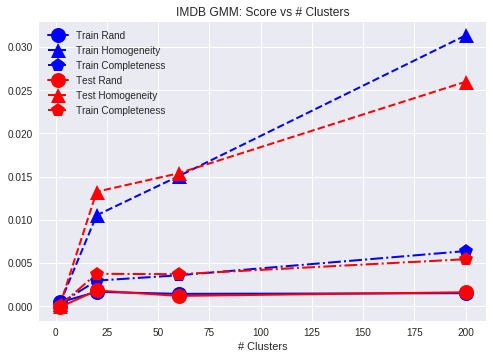

In [0]:
parameter_experiment_mixin(chosen_mixin, train_set, val_set)

## Size Experiment (Optional)

Used to determine the size of training set on performance

[0x00b] | Size Experiment:  0
[0x00c] | Train Fraction:  0.1  of  0.8
[0x001] | Run Configuration:  {'pipeline': [('clust', <class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>, {'n_components': 400, 'max_iter': 100, 'covariance_type': 'spherical', 'n_init': 1})], 'training': {'reps': 1}}
[0x00d] | Finished in  30.816951990127563  seconds
[0x00e] | Average Train Scores:  [0.00205954 0.05187182 0.0191432 ]
[0x00f] | Average Test Scores:  [0.00424451 0.01438222 0.00657587]
[0x00b] | Size Experiment:  1
[0x00c] | Train Fraction:  0.2  of  0.8
[0x001] | Run Configuration:  {'pipeline': [('clust', <class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>, {'n_components': 400, 'max_iter': 100, 'covariance_type': 'spherical', 'n_init': 1})], 'training': {'reps': 1}}
[0x00d] | Finished in  75.28698420524597  seconds
[0x00e] | Average Train Scores:  [0.00162355 0.04924925 0.01218135]
[0x00f] | Average Test Scores:  [0.00217586 0.0145479  0.00408638]
[0x00b] | Size Experiment:  2
[0x00c]

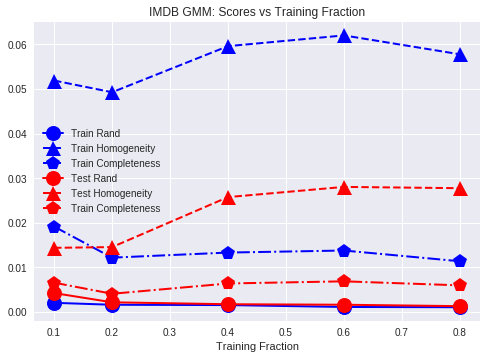

In [0]:
size_experiment_mixin(chosen_mixin, train_set)

# Dimensionality Reduction & Associated Experiments 

The DimRed/Clustering/NeuralNetwork experiments are in here too! Literally everything else that matters lmoa

## Principal Components Analysis & Experiments

### Train Various PCA configurations

In order to proceed with experiments / visualizations, only one configuration can be in the list!

In [0]:
pca_configs = [
    # Let's pick this!
    {KEY_PIPELINE: [(KEY_PREPROC, StandardScaler, {"with_mean": True, "with_std": True}),
                    (KEY_DIMRED, PCA, {"n_components": 300, "copy": True, "whiten": True, "tol": 0,}),],
     KEY_TRAINING: {KEY_REPS: 1},},
]
pca_pipelines = [None] * len(pca_configs)

for index, cfg in enumerate(pca_configs):
    print("[0x024] | " + "PCA Run ", index)
    print("[0x025] | " + "Configuration: ", cfg)
    
    pipeline = get_pipeline(cfg[KEY_PIPELINE])
    start_time = time.time()
    warnings.filterwarnings(action='ignore', category=DataConversionWarning)
       
    pca_pipelines[index] = pipeline
    pca_pipelines[index].fit(train_set[0])
    
    warnings.resetwarnings()
    end_time = time.time()
    print("[0x026] | " + "Finished in ", (end_time - start_time), " seconds")

[0x024] | PCA Run  0
[0x025] | Configuration:  {'pipeline': [('preproc', <class 'sklearn.preprocessing.data.StandardScaler'>, {'with_mean': True, 'with_std': True}), ('dimred', <class 'sklearn.decomposition.pca.PCA'>, {'n_components': 300, 'copy': True, 'whiten': True, 'tol': 0})], 'training': {'reps': 1}}
[0x026] | Finished in  47.56307864189148  seconds


In [0]:
# Experiments for PCA
tform_name = "PCA"
if len(pca_pipelines) != 1:
    raise RuntimeWarning("Warning: More than one " + tform_name + " configuration detected!!!!!!")   
final_pipeline = pca_pipelines[0]
final_tform = final_pipeline.named_steps[KEY_DIMRED]

### Experiments

#### KMeans Experiments

In [0]:
run_final_experiments(km_mixins, final_pipeline, "PCA", "KMeans",
                      split_datasets, experiment_flags=(True, True, False, False),
                      verbose=0)

[0x010] | WARNING: Discarding all but the last entry of clusterspec
[0x041] | ===============================================================
[0x042] | ===============================================================
[0x043] | Experiment: Clustering of raw data
[0x044] | 
[0x017] | Train Results:  [0.00290186 0.08150666 0.01666348]
[0x018] | Val Results:  [0.00287989 0.06447624 0.01411454]
[0x019] | Test Results:  [0.00181229 0.04636605 0.01025002]
[0x013] | ===============================================================
[0x014] | ===============================================================
[0x015] | Experiment: Clustering of dim-reduced data
[0x016] | 
[0x017] | Train Results:  [0.00639361 0.0660576  0.03356592]
[0x018] | Val Results:  [0.01061439 0.03248546 0.02449979]
[0x019] | Test Results:  [0.01141604 0.03418549 0.02593206]
[0x046] | ===============================================================
[0x047] | ===============================================================
[0x049] 

(Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=False, with_std=False)), ('clust', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
     n_clusters=400, n_init=1, n_jobs=5, precompute_distances='auto',
     random_state=None, tol=0.001, verbose=0))]), Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dimred', PCA(copy=True, iterated_power='auto', n_components=300, random_state=None,
   svd_solver='auto', tol=0, whiten=True))]), Pipeline(memory=None,
      steps=[('dimred', Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dimred', PCA(copy=True, iterated_power='auto', n_components=300, random_state=None,
   svd_solver='auto', tol=0, whiten=True))])), ('clust', Pipeline(memory=None,
      steps=[('clust', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
     n_clusters=400, n_init=1, n_jobs=5, pr

#### GMM Experiments

In [0]:
run_final_experiments(gmm_mixins, final_pipeline, "PCA", "GMM",
                      split_datasets, experiment_flags=(True, True, False, False),
                      verbose=0)

/usr/local/lib/python3.6/dist-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


[0x041] | ===============================================================
[0x042] | ===============================================================
[0x043] | Experiment: Clustering of raw data
[0x044] | 
[0x017] | Train Results:  [0.00158507 0.06344711 0.01241523]
[0x018] | Val Results:  [0.00152657 0.03088016 0.00651877]
[0x019] | Test Results:  [0.00100255 0.02396039 0.00506851]
[0x013] | ===============================================================
[0x014] | ===============================================================
[0x015] | Experiment: Clustering of dim-reduced data
[0x016] | 
[0x017] | Train Results:  [0.00048449 0.04840407 0.01337863]
[0x018] | Val Results:  [0.00122434 0.01344386 0.00448022]
[0x019] | Test Results:  [0.00031376 0.0109782  0.00365149]
[0x046] | ===============================================================
[0x047] | ===============================================================
[0x049] | Experiment: Comparison of CL and DRCL Pipelines
[0x049] | 
[0x04a]

(Pipeline(memory=None,
      steps=[('clust', GaussianMixture(covariance_type='spherical', init_params='kmeans',
         max_iter=100, means_init=None, n_components=400, n_init=1,
         precisions_init=None, random_state=None, reg_covar=1e-06,
         tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
         weights_init=None))]), Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dimred', PCA(copy=True, iterated_power='auto', n_components=300, random_state=None,
   svd_solver='auto', tol=0, whiten=True))]), Pipeline(memory=None,
      steps=[('dimred', Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dimred', PCA(copy=True, iterated_power='auto', n_components=300, random_state=None,
   svd_solver='auto', tol=0, whiten=True))])), ('clust', Pipeline(memory=None,
      steps=[(...        tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
         

### Visualizations

In [0]:
# Reconstruction takes about a minute...

recons_dataset = np.clip(val_set[0], 0, 1)
tform_dim = pca_num_components(final_tform)
transformed_data = final_pipeline.transform(recons_dataset)
reconstructions = final_pipeline.inverse_transform(transformed_data)
tform_axes = final_tform.components_

print("[0x027] | " + tform_name + "-Transformed Data: ", transformed_data.shape)
print("[0x028] | " + tform_name + " Reductions: ", reconstructions.shape)
print("[0x029] | " + tform_name + " Axes: ", tform_axes.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


[0x027] | PCA-Transformed Data:  (2400, 1000)
[0x028] | PCA Reductions:  (2400, 10000)
[0x029] | PCA Axes:  (1000, 10000)


[0x02a] | The Number of Components found by PCA was:  1000
[0x05f] | =====================================================
[0x060] | =====================================================
[0x061] | Axis Visualizations
[0x062] | Axis  0 : ['also bad charact come could director end even film first get go good know like look made make man mani movi much never one peopl play realli say scene see seem stori take thing think time tri two want watch way well work would']
[0x062] | Axis  1 : ['bad like movi watch']
[0x062] | Axis  2 : ['also back charact come end episod even first get girl go good know like look love make man one peopl play say seri show stori take thing time two way well would']
[0x062] | Axis  3 : ['bad even film get go good guy like look peopl realli say show thing think want watch would']
[0x062] | Axis  4 : ['bad ever get go guy kill like look one thing watch zombi']
[0x062] | Axis  5 : ['episod film great love movi one season seri show time tv watch would year']
[0x062] |

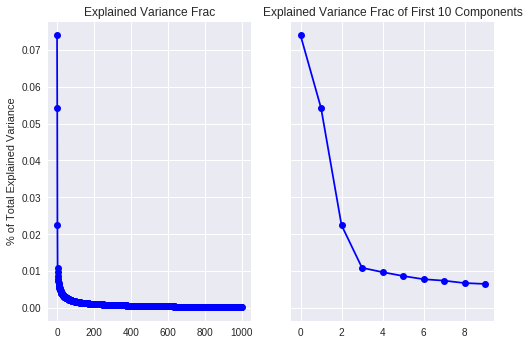

In [0]:
############################
# Customizeable Parameters #
############################
axis_num_display = 10
axis_sig_thresh = .05

comp_num_display = 10
comp_sig_thresh = .5

pca_top_n = 10

#######################################################################

# Fairly obvious what happens here
print("[0x02a] | " + "The Number of Components found by", tform_name, "was: ", tform_dim)
  
print("[0x05f] |", "=====================================================")
print("[0x060] |", "=====================================================")
print("[0x061] |", "Axis Visualizations")
for index, topic_string in enumerate(visualize_word_components(tform_axes, 
                                                               vectorizer, 
                                                               axis_num_display, 
                                                               axis_sig_thresh)):
    print("[0x062] |", "Axis ", index, ":", topic_string)

print("[0x062] |", "=====================================================")
print("[0x063] |", "=====================================================")
print("[0x064] |", "Reconstruction Experiment")
avg_dist = np.average(np.linalg.norm((recons_dataset - reconstructions) / np.sum(recons_dataset, 
                                                                                 axis=1, 
                                                                                 keepdims=True), 
                                     axis=1, ord=1))
print("[0x065] |", "Average L1 dist RATIO between a bag-of-words and reconstruction is ", avg_dist)

for i in range(comp_num_display):
    print("[0x069] |", "{")
    print("[0x06b] |", "    original: ", countvec_to_string(vectorizer, recons_dataset[i]))
    print("[0x06b] |", "    reconstr: ", countvec_to_string(vectorizer, 
                                                            threshold_countvecs(reconstructions[i], 
                                                                                comp_sig_thresh)))
    print("[0x06a] |", "}")

print("[0x066] |", "=====================================================")
print("[0x067] |", "=====================================================")
print("[0x068] |", "Distribution of Eigenvalues")
# Plot the distribution of explained variances
pca_top_n = 10 # min(5 * 2, pca_dim)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.set_title("Explained Variance Frac")
ax1.set(ylabel="% of Total Explained Variance")
ax2.set_title("Explained Variance Frac of First " + str(pca_top_n) + " Components")
ax1.plot(np.arange(pca_num_components(final_tform)), pca_explained_variance_ratio(final_tform), 'bo-')
ax2.plot(np.arange(pca_top_n), pca_explained_variance_ratio(final_pca)[:pca_top_n], 'bo-')

 ## Independent Components Analysis & Experiments



### Train Various ICA Configs

In [0]:
# Complexity Looks like O(max_iter * n^2)
# Ica with .001 data and no component limit is .78s
# Ica with .01 data and no component limit is 79s
# ICA with .02 data and no component limit is 320s 
# ICA with .02 data and 200 components is 13.03s
# ICA with .5 data and 200 components 224s [and converges]
# ICA with .5 data and 400 components 373s [and converges]
# ICA with 1 data and 200 components 373s [and converges]

ica_configs = [
    # Balances reconstruction power with number of dimensions, I like this
    {KEY_PIPELINE: [(KEY_PREPROC, StandardScaler, {"with_mean": True, "with_std": True}),
                  (KEY_DIMRED, FastICA, {"n_components": 300, "max_iter": 200, "whiten": True, "tol": 0.001,}),],
     KEY_TRAINING: {KEY_REPS: 1},},
]

ica_pipelines = [None] * len(ica_configs)

for index, cfg in enumerate(ica_configs):
    print("[0x02b] | " + "ICA Run ", index)
    print("[0x02c] | " + "Configuration: ", cfg)
    
    pipeline = get_pipeline(cfg[KEY_PIPELINE])
    start_time = time.time()
    warnings.filterwarnings(action='ignore', category=DataConversionWarning)
       
    ica_pipelines[index] = pipeline
    ica_pipelines[index].fit(train_set[0])
    
    warnings.resetwarnings()
    end_time = time.time()
    print("[0x02d] | " + "Finished in ", (end_time - start_time), " seconds")

[0x02b] | ICA Run  0
[0x02c] | Configuration:  {'pipeline': [('preproc', <class 'sklearn.preprocessing.data.StandardScaler'>, {'with_mean': True, 'with_std': True}), ('dimred', <class 'sklearn.decomposition.fastica_.FastICA'>, {'n_components': 300, 'max_iter': 200, 'whiten': True, 'tol': 0.001})], 'training': {'reps': 1}}
[0x02d] | Finished in  908.2003161907196  seconds


In [0]:
# Experiments for ICA
tform_name = "ICA"
if len(ica_pipelines) != 1:
    raise RuntimeWarning("Warning: More than one " + tform_name + " configuration detected!!!!!!")   
final_pipeline = ica_pipelines[0]
final_tform = final_pipeline.named_steps[KEY_DIMRED]

### Experiments

#### KMeans Experiments

In [0]:
run_final_experiments(km_mixins, final_pipeline, "ICA", "KMeans",
                      split_datasets, experiment_flags=(True, True, False, False),
                      verbose=0)

[0x010] | WARNING: Discarding all but the last entry of clusterspec
[0x041] | ===============================================================
[0x042] | ===============================================================
[0x043] | Experiment: Clustering of raw data
[0x044] | 
[0x017] | Train Results:  [0.00262974 0.07584972 0.01505149]
[0x018] | Val Results:  [0.0024222  0.04122756 0.00877829]
[0x019] | Test Results:  [0.0018854  0.0453967  0.00970793]
[0x013] | ===============================================================
[0x014] | ===============================================================
[0x015] | Experiment: Clustering of dim-reduced data
[0x016] | 
[0x017] | Train Results:  [0.01748896 0.09279553 0.0474762 ]
[0x018] | Val Results:  [0.02195925 0.05727762 0.04400035]
[0x019] | Test Results:  [0.02321926 0.05849027 0.04617654]
[0x046] | ===============================================================
[0x047] | ===============================================================
[0x049] 

(Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=False, with_std=False)), ('clust', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
     n_clusters=400, n_init=1, n_jobs=5, precompute_distances='auto',
     random_state=None, tol=0.001, verbose=0))]), Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dimred', FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
     n_components=300, random_state=None, tol=0.001, w_init=None,
     whiten=True))]), Pipeline(memory=None,
      steps=[('dimred', Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dimred', FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
     n_components=300, random_state=None, tol=0.001, w_init=None,
     whiten=True))])), ('clu..., n_init=1, n_jobs=5, precompute_distances='auto',
     random_state=None, tol

#### GMM Experiments

In [0]:
run_final_experiments(gmm_mixins, final_pipeline, "ICA", "GMM",
                      split_datasets, experiment_flags=(True, True, False, False),
                      verbose=0)

/usr/local/lib/python3.6/dist-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


[0x041] | ===============================================================
[0x042] | ===============================================================
[0x043] | Experiment: Clustering of raw data
[0x044] | 
[0x017] | Train Results:  [0.00158128 0.05998473 0.01136447]
[0x018] | Val Results:  [0.00097167 0.03666192 0.00744586]
[0x019] | Test Results:  [0.00039367 0.01939588 0.00393708]
[0x013] | ===============================================================
[0x014] | ===============================================================
[0x015] | Experiment: Clustering of dim-reduced data
[0x016] | 
[0x017] | Train Results:  [0.00052606 0.04751222 0.01581669]
[0x018] | Val Results:  [0.0002553  0.01211569 0.00507906]
[0x019] | Test Results:  [-2.96017490e-05  1.03092436e-02  4.32530456e-03]
[0x046] | ===============================================================
[0x047] | ===============================================================
[0x049] | Experiment: Comparison of CL and DRCL Pipelines
[0x

(Pipeline(memory=None,
      steps=[('clust', GaussianMixture(covariance_type='spherical', init_params='kmeans',
         max_iter=100, means_init=None, n_components=400, n_init=1,
         precisions_init=None, random_state=None, reg_covar=1e-06,
         tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
         weights_init=None))]), Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dimred', FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
     n_components=300, random_state=None, tol=0.001, w_init=None,
     whiten=True))]), Pipeline(memory=None,
      steps=[('dimred', Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dimred', FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
     n_components=300, random_state=None, tol=0.001, w_init=None,
     whiten=True))])), ('clu...        tol=0.001, verbose=0, verbose

### Visualizations

In [0]:
# Reconstruction takes about a minute...
recons_dataset = np.clip(val_set[0], 0, 1)
tform_dim = pca_num_components(final_tform)
transformed_data = final_pipeline.transform(recons_dataset)
reconstructions = final_pipeline.inverse_transform(transformed_data)
tform_axes = final_tform.components_

print("[0x027] | " + tform_name + "-Transformed Data: ", transformed_data.shape)
print("[0x028] | " + tform_name + " Reductions: ", reconstructions.shape)
print("[0x029] | " + tform_name + " Axes: ", tform_axes.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


[0x027] | ICA-Transformed Data:  (2400, 300)
[0x028] | ICA Reductions:  (2400, 10000)
[0x029] | ICA Axes:  (300, 10000)


In [0]:
############################
# Customizeable Parameters #
############################
axis_num_display = 10
axis_sig_thresh = .0002

comp_num_display = 10
comp_sig_thresh = .2

#######################################################################

# Fairly obvious what happens here
print("[0x02a] | " + "The Number of Components found by", tform_name, "was: ", tform_dim)
  
print("[0x05f] |", "=====================================================")
print("[0x060] |", "=====================================================")
print("[0x061] |", "Axis Visualizations")
for index, topic_string in enumerate(visualize_word_components(tform_axes, 
                                                               vectorizer, 
                                                               axis_num_display, 
                                                               axis_sig_thresh)):
    print("[0x062] |", "Axis ", index, ":", topic_string)

print("[0x062] |", "=====================================================")
print("[0x063] |", "=====================================================")
print("[0x064] |", "Reconstruction Experiment")
avg_dist = np.average(np.linalg.norm((recons_dataset - reconstructions) / np.sum(recons_dataset, 
                                                                                 axis=1, 
                                                                                 keepdims=True), 
                                     axis=1, ord=1))
print("[0x065] |", "Average L1 dist RATIO between a bag-of-words and reconstruction is ", avg_dist)

for i in range(comp_num_display):
    print("[0x069] |", "{")
    print("[0x06b] |", "    original: ", countvec_to_string(vectorizer, recons_dataset[i]))
    print("[0x06b] |", "    reconstr: ", countvec_to_string(vectorizer, 
                                                            threshold_countvecs(reconstructions[i], 
                                                                                comp_sig_thresh)))
    print("[0x06a] |", "}")

[0x02a] | The Number of Components found by ICA was:  300
[0x05f] | =====================================================
[0x060] | =====================================================
[0x061] | Axis Visualizations
[0x062] | Axis  0 : ['affirm agenda belief belli bibl biblic bombard callou carlin categor christ christian church debat deceiv disclaim discuss epilogu god inaccur insur jesu joseph marbl messag moral orthodox overt phenomena raptur religi religion represent scholar secondli skeptic sledgehamm smug tactic theolog thirdli threat ufo warp']
[0x062] | Axis  1 : ['']
[0x062] | Axis  2 : ['']
[0x062] | Axis  3 : ['albert alejandro ami amor andi cartoonish cassandra concoct crackl daddi decept delusion devil eerili embezzl encompass estim ethan feroci finney flourish gamut gina hank haul hawk hoffman holden imbu innat insuffer interven ir jenkin jewelri juici katharin lumet marisa masterson mommi payment pinch pivot pov reptil rosemari sear seymour shakespearean sidney snippet s

 ## Randomized Projections

### Training the RCA configs

In [0]:
class i_GRP(GRP):
  def inverse_transform(self, X):
      return np.matmul(X, ensure_numpy(self.components_))

rp_configs = [
    # Bad performance lmoa, but takes five seconds with 100% data!
    # As good as we're going to get, given that we're not reducing dimensionality at all
    {KEY_PIPELINE: [(KEY_PREPROC, StandardScaler, {"with_mean": True, "with_std": True}),
                  (KEY_DIMRED, i_GRP, {"n_components": 3072, "eps": 0.1,}),],
     KEY_TRAINING: {KEY_REPS: 1},},
]

rp_pipelines = [None] * len(rp_configs)

for index, cfg in enumerate(rp_configs):
    print("[0x032] | " + "RP Run ", index)
    print("[0x033] | " + "Configuration: ", cfg)
    
    pipeline = get_pipeline(cfg[KEY_PIPELINE])
    start_time = time.time()
    warnings.filterwarnings(action='ignore', category=DataConversionWarning)
       
    rp_pipelines[index] = pipeline
    rp_pipelines[index].fit(train_set[0])
    
    warnings.resetwarnings()
    end_time = time.time()
    print("[0x034] | " + "Finished in ", (end_time - start_time), " seconds")


[0x032] | RP Run  0
[0x033] | Configuration:  {'pipeline': [('preproc', <class 'sklearn.preprocessing.data.StandardScaler'>, {'with_mean': True, 'with_std': True}), ('dimred', <class '__main__.i_GRP'>, {'n_components': 3072, 'eps': 0.1})], 'training': {'reps': 1}}
[0x034] | Finished in  3.892467737197876  seconds


In [0]:
# Experiments for RP

tform_name = "RP"
if len(pca_pipelines) != 1:
    raise RuntimeWarning("Warning: More than one " + tform_name + " configuration detected!!!!!!")   
final_pipeline = rp_pipelines[0]
final_tform = final_pipeline.named_steps[KEY_DIMRED]

### Experiments

#### KMeans Experiments

In [0]:
run_final_experiments(km_mixins, final_pipeline, "RandProj", "KMeans",
                      split_datasets, experiment_flags=(True, True, False, False),
                      verbose=0)

[0x010] | WARNING: Discarding all but the last entry of clusterspec
[0x041] | ===============================================================
[0x042] | ===============================================================
[0x043] | Experiment: Clustering of raw data
[0x044] | 
[0x017] | Train Results:  [0.00300096 0.06524059 0.01507257]
[0x018] | Val Results:  [0.00220791 0.04099066 0.01025205]
[0x019] | Test Results:  [0.00125427 0.0249903  0.00626546]
[0x013] | ===============================================================
[0x014] | ===============================================================
[0x015] | Experiment: Clustering of dim-reduced data
[0x016] | 
[0x017] | Train Results:  [0.00025917 0.04261501 0.03213889]
[0x018] | Val Results:  [4.16399414e-05 1.03759791e-02 1.11315704e-02]
[0x019] | Test Results:  [-0.0002478   0.00596644  0.0064157 ]
[0x046] | ===============================================================
[0x047] | =========================================================

(Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=False, with_std=False)), ('clust', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
     n_clusters=400, n_init=1, n_jobs=5, precompute_distances='auto',
     random_state=None, tol=0.001, verbose=0))]), Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dimred', i_GRP(eps=0.1, n_components=3072, random_state=None))]), Pipeline(memory=None,
      steps=[('dimred', Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dimred', i_GRP(eps=0.1, n_components=3072, random_state=None))])), ('clust', Pipeline(memory=None,
      steps=[('clust', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
     n_clusters=400, n_init=1, n_jobs=5, precompute_distances='auto',
     random_state=None, tol=0.001, verbose=0))]))]), <__main__.OneHotted_ClusterPipeline at 0x7fdc93d

#### GMM Experiments

In [0]:
run_final_experiments(gmm_mixins, final_pipeline, "RandProj", "GMM",
                      split_datasets, experiment_flags=(True, True, False, False),
                      verbose=0)

[0x041] | ===============================================================
[0x042] | ===============================================================
[0x043] | Experiment: Clustering of raw data
[0x044] | 
[0x017] | Train Results:  [0.00167834 0.06438481 0.01272171]
[0x018] | Val Results:  [0.0017659  0.03339458 0.00706491]
[0x019] | Test Results:  [0.00089507 0.02366743 0.00501616]
[0x013] | ===============================================================
[0x014] | ===============================================================
[0x015] | Experiment: Clustering of dim-reduced data
[0x016] | 
[0x017] | Train Results:  [0.00026622 0.04193074 0.01534766]
[0x018] | Val Results:  [0.00065084 0.0019979  0.00090041]
[0x019] | Test Results:  [0.00017111 0.00142919 0.00064212]
[0x046] | ===============================================================
[0x047] | ===============================================================
[0x049] | Experiment: Comparison of CL and DRCL Pipelines
[0x049] | 
[0x04a]

(Pipeline(memory=None,
      steps=[('clust', GaussianMixture(covariance_type='spherical', init_params='kmeans',
         max_iter=100, means_init=None, n_components=400, n_init=1,
         precisions_init=None, random_state=None, reg_covar=1e-06,
         tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
         weights_init=None))]), Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dimred', i_GRP(eps=0.1, n_components=3072, random_state=None))]), Pipeline(memory=None,
      steps=[('dimred', Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dimred', i_GRP(eps=0.1, n_components=3072, random_state=None))])), ('clust', Pipeline(memory=None,
      steps=[('clust', GaussianMixture(covariance_type='spherical', init_para...        tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
         weights_init=None))]))]), <__main__.OneHotted_ClusterPipeline at 

### Visualizations

In [0]:
# def invert_rp(projection, projected_data):
#     proj_axes = projection.components_
#     try:
#         proj_axes = proj_axes.toarray()
#     except AttributeError:
#         pass      
#     return np.matmul(projected_data, proj_axes)
  
# TODO Why does GRP not support inverse_transform?! This is a crime!!
# def invert_rp_pipeline(pipeline, projected_data):
#     tform = lambda x: x
#     if pipeline.named_steps[KEY_PREPROC] is not None:
#         tform = lambda x: pipeline.named_steps[KEY_PREPROC].inverse_transform(x)
#     return tform(invert_rp(pipeline.named_steps[KEY_DIMRED], projected_data))

# Reconstruction takes about a minute...
# rp_recons_dataset = val_set[0]
# rp_dim = pca_num_components(final_rp)
# rp_transformed_data = final_rp_pipeline.transform(rp_recons_dataset)
# rp_reconstructions = invert_rp_pipeline(final_rp_pipeline, rp_transformed_data)
# rp_axes = final_rp.components_

# print("[0x035] | " + "RP-Transformed Data: ", rp_transformed_data.shape)
# print("[0x036] | " + "RP Reconstruction: ", rp_reconstructions.shape)
# print("[0x037] | " + "RP Axes: ", rp_axes.shape)

###############################################################################
recons_dataset = np.clip(val_set[0], 0, 1)
tform_dim = pca_num_components(final_tform)
transformed_data = final_pipeline.transform(recons_dataset)
reconstructions = final_pipeline.inverse_transform(transformed_data)
tform_axes = final_tform.components_

print("[0x027] | " + tform_name + "-Transformed Data: ", transformed_data.shape)
print("[0x028] | " + tform_name + " Reductions: ", reconstructions.shape)
print("[0x029] | " + tform_name + " Axes: ", tform_axes.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


[0x027] | RP-Transformed Data:  (2400, 3072)
[0x028] | RP Reductions:  (2400, 10000)
[0x029] | RP Axes:  (3072, 10000)


In [0]:
############################
# Customizeable Parameters #
############################
axis_num_display = 10
axis_sig_thresh = .055

comp_num_display = 10
comp_sig_thresh = .7

#######################################################################

# Fairly obvious what happens here
print("[0x02a] | " + "The Number of Components found by", tform_name, "was: ", tform_dim)
  
print("[0x05f] |", "=====================================================")
print("[0x060] |", "=====================================================")
print("[0x061] |", "Axis Visualizations")
for index, topic_string in enumerate(visualize_word_components(tform_axes, 
                                                               vectorizer, 
                                                               axis_num_display, 
                                                               axis_sig_thresh)):
    print("[0x062] |", "Axis ", index, ":", topic_string)

print("[0x062] |", "=====================================================")
print("[0x063] |", "=====================================================")
print("[0x064] |", "Reconstruction Experiment")
avg_dist = np.average(np.linalg.norm((recons_dataset - reconstructions) / np.sum(recons_dataset, 
                                                                                 axis=1, 
                                                                                 keepdims=True), 
                                     axis=1, ord=1))
print("[0x065] |", "Average L1 dist RATIO between a bag-of-words and reconstruction is ", avg_dist)

for i in range(comp_num_display):
    print("[0x069] |", "{")
    print("[0x06b] |", "    original: ", countvec_to_string(vectorizer, recons_dataset[i]))
    print("[0x06b] |", "    reconstr: ", countvec_to_string(vectorizer, 
                                                            threshold_countvecs(reconstructions[i], 
                                                                                comp_sig_thresh)))
    print("[0x06a] |", "}")

[0x02a] | The Number of Components found by RP was:  3072
[0x05f] | =====================================================
[0x060] | =====================================================
[0x061] | Axis Visualizations
[0x062] | Axis  0 : ['abort anyway der dope fonda mine simultan sprawl support vin wimp']
[0x062] | Axis  1 : ['adult clara crosbi flock gripe juic light mauric moto perspect rapidli republ scorses strap sweetheart watch']
[0x062] | Axis  2 : ['bu circul comanch fake furthermor holi manic retir rub undemand variat']
[0x062] | Axis  3 : ['africa aimlessli dam hormon kim meaning pistol pope']
[0x062] | Axis  4 : ['appar autist british cal charl consult fashion meat meek pole premis purchas quicki receiv replac rpg stealth undeni']
[0x062] | Axis  5 : ['bulb chubbi coal flop hyde journal misunderstood orthodox rifl solut']
[0x062] | Axis  6 : ['dassin follow katharin keeper milieu patton ridley scholar sherman upbeat wimpi woman']
[0x062] | Axis  7 : ['ang back beth east fame 

## Variance-Threshold feature selection

### Training the FeatureSelector Configs

In [0]:
fs_configs = [
    # Looks kinda dumb, but not *totally* dumb
    {KEY_PIPELINE: [(KEY_DIMRED, VTSelector, {"threshold": .1,})], KEY_TRAINING: {KEY_REPS: 1},},
]

fs_pipelines = [None] * len(fs_configs)

for index, cfg in enumerate(fs_configs):
    print("[0x039] | " + "FS Run ", index)
    print("[0x03a] | " + "Configuration: ", cfg)
    
    pipeline = get_pipeline(cfg[KEY_PIPELINE])
    start_time = time.time()
    warnings.filterwarnings(action='ignore', category=DataConversionWarning)
       
    fs_pipelines[index] = pipeline
    fs_pipelines[index].fit(train_set[0])
    
    warnings.resetwarnings()
    end_time = time.time()
    print("[0x03b] | " + "Finished in ", (end_time - start_time), " seconds")

[0x039] | FS Run  0
[0x03a] | Configuration:  {'pipeline': [('dimred', <class 'sklearn.feature_selection.variance_threshold.VarianceThreshold'>, {'threshold': 0.1})], 'training': {'reps': 1}}
[0x03b] | Finished in  0.9005234241485596  seconds


In [0]:
# Experiments for FS
tform_name = "FS"
if len(fs_pipelines) != 1:
    raise RuntimeWarning("Warning: More than one " + tform_name + " configuration detected!!!!!!")   
final_pipeline = fs_pipelines[0]
final_tform = final_pipeline.named_steps[KEY_DIMRED]

### Experiments

#### KMeans Experiments

In [0]:
run_final_experiments(km_mixins, final_pipeline, "VarianceSelection", "KMeans",
                      split_datasets, experiment_flags=(True, True, False, False),
                      verbose=0)

[0x010] | WARNING: Discarding all but the last entry of clusterspec
[0x041] | ===============================================================
[0x042] | ===============================================================
[0x043] | Experiment: Clustering of raw data
[0x044] | 
[0x017] | Train Results:  [0.00342561 0.0742545  0.0161565 ]
[0x018] | Val Results:  [0.00244703 0.04061968 0.00949296]
[0x019] | Test Results:  [0.003441   0.03837674 0.00898192]
[0x013] | ===============================================================
[0x014] | ===============================================================
[0x015] | Experiment: Clustering of dim-reduced data
[0x016] | 
[0x017] | Train Results:  [0.00163682 0.09961921 0.01590488]
[0x018] | Val Results:  [0.00098731 0.09240784 0.01533152]
[0x019] | Test Results:  [0.00084904 0.07559703 0.01264613]
[0x046] | ===============================================================
[0x047] | ===============================================================
[0x049] 

(Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=False, with_std=False)), ('clust', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
     n_clusters=400, n_init=1, n_jobs=5, precompute_distances='auto',
     random_state=None, tol=0.001, verbose=0))]),
 Pipeline(memory=None, steps=[('dimred', VarianceThreshold(threshold=0.1))]),
 Pipeline(memory=None,
      steps=[('dimred', Pipeline(memory=None, steps=[('dimred', VarianceThreshold(threshold=0.1))])), ('clust', Pipeline(memory=None,
      steps=[('clust', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
     n_clusters=400, n_init=1, n_jobs=5, precompute_distances='auto',
     random_state=None, tol=0.001, verbose=0))]))]),
 <__main__.OneHotted_ClusterPipeline at 0x7fdc92890710>)

#### GMM Experiments

In [0]:
run_final_experiments(gmm_mixins, final_pipeline, "VarianceSelection", "GMM",
                      split_datasets, experiment_flags=(True, True, False, False),
                      verbose=0)

/usr/local/lib/python3.6/dist-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


[0x041] | ===============================================================
[0x042] | ===============================================================
[0x043] | Experiment: Clustering of raw data
[0x044] | 
[0x017] | Train Results:  [0.00164925 0.06736416 0.01287482]
[0x018] | Val Results:  [0.00146156 0.04492795 0.00912123]
[0x019] | Test Results:  [0.00129449 0.03254903 0.00666763]
[0x013] | ===============================================================
[0x014] | ===============================================================
[0x015] | Experiment: Clustering of dim-reduced data
[0x016] | 
[0x017] | Train Results:  [0.00091203 0.09516662 0.01403245]
[0x018] | Val Results:  [0.00064438 0.08192107 0.01272454]
[0x019] | Test Results:  [0.00039179 0.06921806 0.01078655]
[0x046] | ===============================================================
[0x047] | ===============================================================
[0x049] | Experiment: Comparison of CL and DRCL Pipelines
[0x049] | 
[0x04a]

(Pipeline(memory=None,
      steps=[('clust', GaussianMixture(covariance_type='spherical', init_params='kmeans',
         max_iter=100, means_init=None, n_components=400, n_init=1,
         precisions_init=None, random_state=None, reg_covar=1e-06,
         tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
         weights_init=None))]),
 Pipeline(memory=None, steps=[('dimred', VarianceThreshold(threshold=0.1))]),
 Pipeline(memory=None,
      steps=[('dimred', Pipeline(memory=None, steps=[('dimred', VarianceThreshold(threshold=0.1))])), ('clust', Pipeline(memory=None,
      steps=[('clust', GaussianMixture(covariance_type='spherical', init_params='kmeans',
         max_iter=100, means_init=None, n_components=400, n_init=1,
         precisions_init=None, random_state=None, reg_covar=1e-06,
         tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
         weights_init=None))]))]),
 <__main__.OneHotted_ClusterPipeline at 0x7fdc9309c4a8>)

### Visualizations

In [0]:
# Reconstruction takes about a minute...
recons_dataset = val_set[0]
transformed_data = final_pipeline.transform(recons_dataset)
tform_dim = transformed_data.shape[1]
reconstructions = final_pipeline.inverse_transform(transformed_data)

__mapped_all = final_pipeline.transform(np.ones(MAX_WORD_FEATURES).reshape(1, -1))
chosen_components = final_pipeline.inverse_transform(__mapped_all)

print("[0x03c] | " + tform_name + "-Transformed Data: ", transformed_data.shape)
print("[0x03d] | " + tform_name + " Reconstructions: ", reconstructions.shape)

[0x03c] | FS-Transformed Data:  (2400, 319)
[0x03d] | FS Reconstructions:  (2400, 10000)


In [0]:
############################
# Customizeable Parameters #
############################
comp_num_display = 10
comp_sig_thresh = .2
#######################################################################

# Fairly obvious what happens here
print("[0x02a] | " + "The Number of Components found by", tform_name, "was: ", tform_dim)
  
print("[0x05f] |", "=====================================================")
print("[0x060] |", "=====================================================")
print("[0x061] |", "Selected words")
print("[0x061] |", countvec_to_string(vectorizer, chosen_components))

print("[0x062] |", "=====================================================")
print("[0x063] |", "=====================================================")
print("[0x064] |", "Reconstruction Experiment")
avg_dist = np.average(np.linalg.norm((recons_dataset - reconstructions) / np.sum(recons_dataset, 
                                                                                 axis=1, 
                                                                                 keepdims=True), 
                                     axis=1, ord=1))
print("[0x065] |", "Average L1 dist RATIO between a bag-of-words and reconstruction is ", avg_dist)

for i in range(comp_num_display):
    print("[0x069] |", "{")
    print("[0x06b] |", "    original: ", countvec_to_string(vectorizer, recons_dataset[i]))
    print("[0x06b] |", "    reconstr: ", countvec_to_string(vectorizer, 
                                                            threshold_countvecs(reconstructions[i], 
                                                                                comp_sig_thresh)))
    print("[0x06a] |", "}")

[0x02a] | The Number of Components found by FS was:  319
[0x05f] | =====================================================
[0x060] | =====================================================
[0x061] | Selected words
[0x061] | ['act action actor actual alien almost also although alway american anim anoth anyon anyth appear around art audienc away back bad beauti becom begin believ best better betti big bit black blood book bore boy brother budget call camera car cartoon cast chang charact charli children classic come comedi complet could coupl cours custer cut danc dark day dead death dian die differ direct director doctor documentari done dream dvd earli effect emot end enjoy enough entertain entir episod especi even ever everi everyon everyth evil excel expect eye face fact famili fan far father featur feel fight film final find first flick follow forc found friend fun funni game gamera gay gener get girl give go god goe good got great guy half hand happen hard hate head help high hollywood